In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
prev_path = "\\".join(list(os.getcwd().split('\\')[0:-1]))
if module_path not in sys.path: sys.path.append(prev_path)

# you will need to pip install eikon=1.1.15 and maybe some other packages
# it's best if we share the venv 

from models.data.source import Eikon
from models.stat_models.linearregression import LinearRegressionModel, MultiOutputLinearRegressionModel
from models.unsupervised.pca import PcaHandler
from models.data.handler import DataHandler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = r'C:\Users\serge\IdeaProjects\portfolio_manager\data\fama-french-factors'
path_apikeys = r'C:\Users\serge\OneDrive\Documents\apikeys.csv'

In [3]:
rics_list = [
    'LVMH.PA', 'ASML.AS', 'NESN.S', 'LIN',
    'NOVOb.CO', 'AAPL.O', 'ROG.S', 'UNH',
    'SAPG.DE', 'MSFT.O'
]

params = {
    'rics': rics_list,
    'field': ['TR.PriceClose', 'Price Close'],
    'date_field': ['TR.PriceClose.calcdate', 'Calc Date'],
    'params': {
        'SDate':'1999-12-31',
        'EDate': '2021-06-04',
        'Curn':'Native',
    },
    'path': r'C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv'
}

In [4]:
N_PCA_COMPONENTS = 5
HORIZON_IN_DAYS = 20
RIC = "ASML.AS"
DOWNLOAD_DATA = False

In [5]:
eikon_api = Eikon(path_apikeys)

In [6]:
# you can download them once and then just load them
if DOWNLOAD_DATA:
    save_path = params['path']
    params.pop('path')
    eikon_api.download_timeseries(**params, save_config={'save': True, 'path': save_path})
else:
    params.pop['params']
    eikon_api.load_timeseries(**params)

LVMH.PA
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\LVMH.PA.csv
ASML.AS
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\ASML.AS.csv
NESN.S
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\NESN.S.csv
LIN
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\LIN.csv
NOVOb.CO
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\NOVOb.CO.csv
AAPL.O
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\AAPL.O.csv
ROG.S
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\ROG.S.csv
UNH
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\UNH.csv
SAPG.DE
Saved: C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv\SAPG.DE.csv
MSFT.O
Saved: C:\Users\serge\Ide

In [7]:
data = eikon_api.data.copy()
data.head(20)

,Calc Date,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE,MSFT.O
0,2000-01-04,72.458651,38.039234,28.0,24.46875,17.55,0.915178,175.423964,6.632812,39.076938,56.3125
1,2000-01-05,70.007313,34.411467,27.8,24.90625,17.136,0.92857,171.065003,6.617188,34.361184,56.90625
2,2000-01-06,69.214234,32.004583,28.96,26.75,17.55,0.848213,172.808587,6.859375,35.475892,55.0
3,2000-01-07,69.214234,34.394026,29.53,26.78125,17.91,0.888392,182.592033,7.664062,43.013639,55.71875
4,2000-01-10,72.134209,36.870674,29.23,26.8125,19.26,0.872767,184.819946,7.53125,44.770651,56.125
5,2000-01-11,73.540123,37.324145,29.3,27.25,19.17,0.828124,183.076362,7.546875,46.204439,54.6875
6,2000-01-12,76.78454,36.80091,29.93,26.78125,18.99,0.778459,183.076362,7.476562,47.157535,52.90625
7,2000-01-13,81.470921,37.202057,30.05,26.40625,18.9,0.863838,183.076362,7.710938,47.654802,53.90625
8,2000-01-14,84.715338,41.597237,30.21,26.71875,18.36,0.896762,184.04502,7.703125,48.732215,56.125
9,2000-01-17,83.814111,43.602974,29.95,26.71875,18.36,0.896762,184.626215,7.703125,47.986314,56.125


In [8]:
data_handler = DataHandler(data=data, date_col=params['date_field'][1])
df = data_handler.get_returns(period=HORIZON_IN_DAYS, out=True)

In [9]:
# T = len(data)
# tau = 12
# df = {}
# for t in np.arange(0, T-tau, tau):
#     df[data.iloc[t+tau,0]]= np.log(data.iloc[t+tau,1:].astype(float).values / data.iloc[t,1:].astype(float).values)
# df = pd.DataFrame.from_dict(df, orient='index')
# df.columns = data.columns[1:]

# this is unit test for tau=12
# assert np.isclose(df.iloc[0,0],np.log(79.848712 / 72.458651))

In [10]:
df.head()

,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE,MSFT.O
2000-01-24,0.065005,0.233634,0.010657,-0.003839,0.020305,0.035932,0.013165,0.039266,0.208832,-0.106471
2000-02-11,-0.047009,0.010471,-0.078630,-0.259036,0.053803,0.023257,0.009492,0.014615,0.120648,-0.013048
2000-03-02,-0.076912,0.067363,0.089175,-0.140676,0.000000,0.114969,-0.001350,-0.064539,0.058945,-0.067921
2000-03-22,0.076179,-0.113302,0.031661,0.140676,0.077842,0.167093,0.039740,0.008299,0.028624,0.100530
2000-04-11,0.047275,-0.069692,0.031018,0.169224,-0.054312,-0.188321,-0.067139,0.211984,-0.336598,-0.207826


In [11]:
pca_model = PcaHandler(np.array(df))

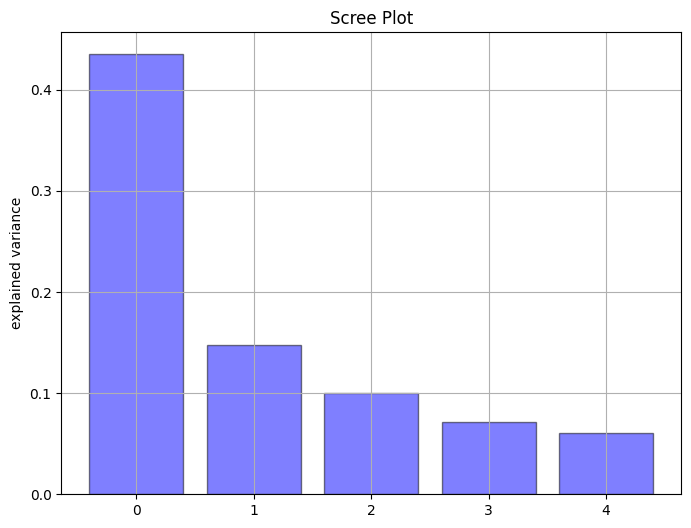

In [12]:
pca_model.plot(N_PCA_COMPONENTS)

In [13]:
pca_factors = pca_model.components(N_PCA_COMPONENTS)
x = pca_factors

In [14]:
pca_model.singular_values

array([2.80800754, 1.63956195, 1.34538217, 1.1375686 , 1.0474914 ,
       0.96050141, 0.93571968, 0.79722691, 0.76380546, 0.56941412])

In [15]:
pca_model.benchmark_test()

[-2.20093041e-17 -6.51605506e-17 -1.73472348e-18 -1.62630326e-17
 -7.37257477e-18 -2.92192485e-17 -1.33898968e-17 -2.49366500e-18
 -3.29326410e-17 -1.89735380e-17]


In [16]:
mod = LinearRegressionModel(x=x, y=np.array(df[RIC]))

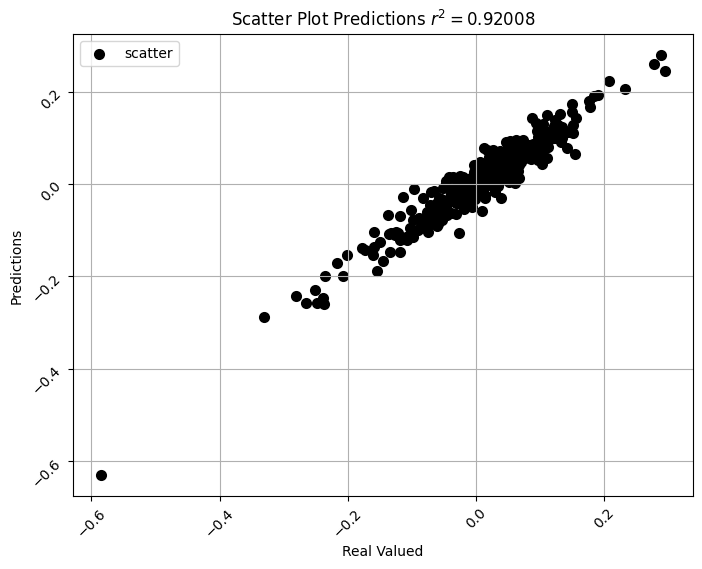

In [17]:
mod.plot()

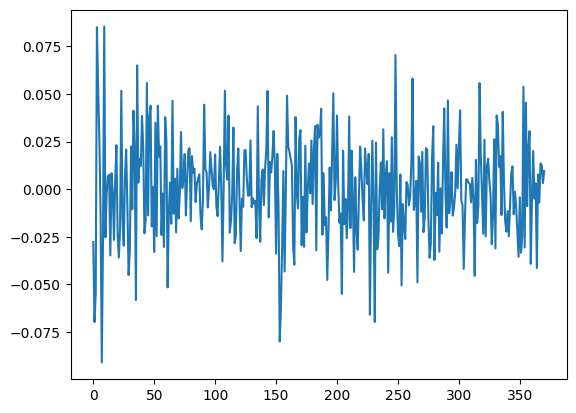

In [18]:
plt.plot(mod.residuals)

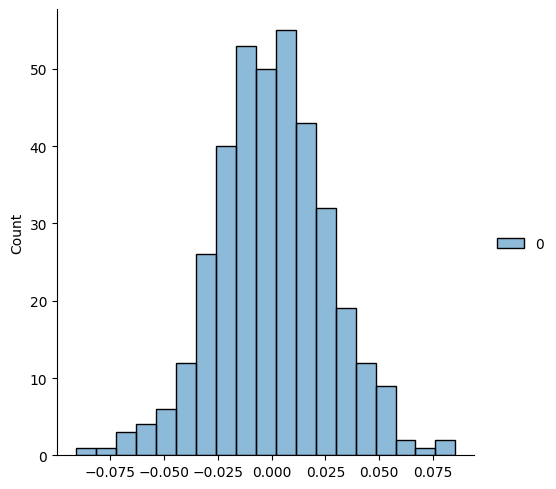

In [19]:
sns.displot(mod.residuals)

In [20]:
## Rolling estimation

In [22]:
T = len(df)
period = int(T/2)
params = {}
for i in range(T):
    try:
        df_sliced = df.iloc[i:i+period, :]
        pca_model = PcaHandler(df_sliced)
        factors = pca_model.components(N_PCA_COMPONENTS)
        mod = LinearRegressionModel(x=factors, y=np.array(df_sliced[RIC]))
        params[i] = mod.beta.flatten()
    except:
        params[i] = np.repeat(np.nan, N_PCA_COMPONENTS)

In [23]:
rolling_betas = pd.DataFrame.from_dict(params, orient='index')

In [24]:
rolling_betas

,0,1,2,3,4,5
0,-0.002308,-0.567204,0.318715,-0.027711,0.467294,8.424754e-03
1,-0.004301,0.562700,-0.317844,0.029738,-0.464318,4.125888e-03
2,-0.004242,0.560293,-0.320162,0.018559,-0.510887,-1.037810e-02
3,-0.004617,-0.559852,0.321827,-0.029194,0.505907,3.825032e-02
4,-0.003480,-0.564834,0.309560,-0.035156,0.473561,-7.687688e-02
...,...,...,...,...,...,...
366,NaN,NaN,NaN,NaN,NaN,NaN
367,NaN,NaN,NaN,NaN,NaN,NaN
368,0.000000,-0.250000,-0.156250,0.000000,0.000000,4.503600e+15
369,NaN,NaN,NaN,NaN,NaN,NaN


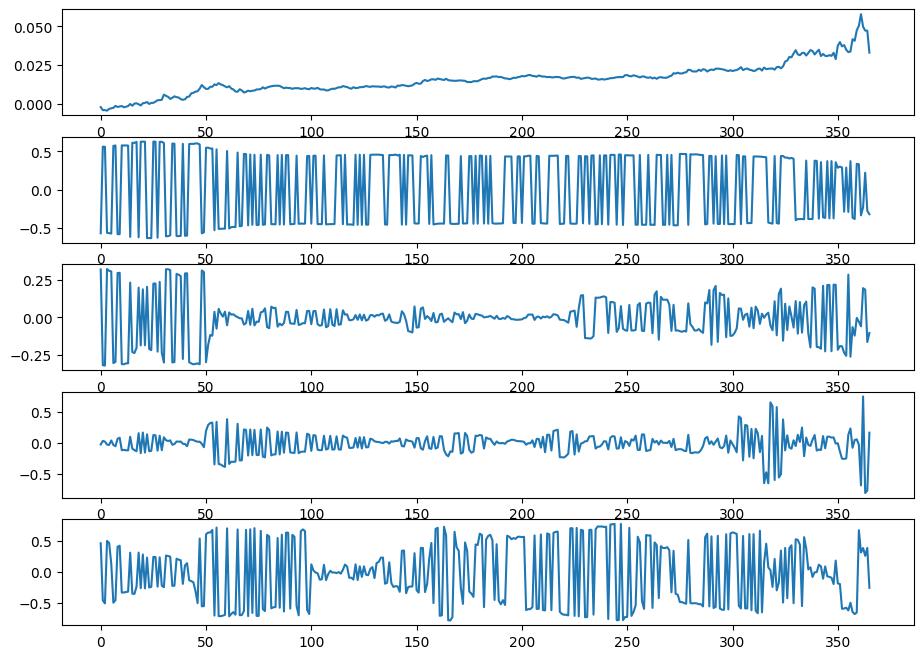

In [25]:
fig, axs = plt.subplots(N_PCA_COMPONENTS,1,figsize=(11,8))
for i in range(N_PCA_COMPONENTS):
    rolling_betas.iloc[:,i].plot(ax=axs[i])
plt.show()

In [ ]:
rolling_betas.dropna()